In [1077]:
# pip install rich numpy pandas matplotlib

import rich, math, sys, time, random, copy
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from rich.console import Console
from rich.live import Live
from rich.text import Text
from dataclasses import dataclass, field, asdict
from typing import List, Dict, Any, Optional, ClassVar, Union
from functools import reduce
from IPython.display import clear_output  # For Jupyter compatibility

In [854]:
# constants
FIRST_PRIMES_BEFORE_200 = [
    2, 3, 5, 7, 11, 13, 17, 19, 23, 29, 31, 37, 41, 43, 47,
    53, 59, 61, 67, 71, 73, 79, 83, 89, 97,
    101, 103, 107, 109, 113, 127, 131, 137, 139, 149,
    151, 157, 163, 167, 173, 179, 181, 191, 193, 197, 199
]

BLE_BANDWIDTH = 1000 * 1000 * 2 # b/s
BLE_BANDWIDTH_B_MS = BLE_BANDWIDTH / 8 / 1000 # B/ms
TIME_PADDING = 1 # ms

@dataclass
class Packet:
    mtu: int = 256 # B

    @property
    def toa(self):
        return self.mtu / BLE_BANDWIDTH_B_MS # about 1.02 ms

PACKET = Packet()

SLOT_INFO = {
    "beacon": {
        "direction": "down",
        "is_shared": True,
        "abbreviation": "B",
        "color": "red",
    },
    "data-down": {
        "direction": "down",
        "is_shared": True,
        "abbreviation": "D",
        "color": "green",
    },
    "data-up": {
        "direction": "up",
        "is_shared": False,
        "abbreviation": "U",
        "color": "yellow",
    },
    "data-shared-up": {
        "direction": "up",
        "is_shared": True,
        "abbreviation": "S",
        "color": "purple",
    },

    # not used anymore -- will just use data-down for carrying join-response packets
    "join-response": {
        "direction": "down",
        "is_shared": True,
        "abbreviation": "R",
        "color": "deep_pink3",
    },

    # so far not used
    "empty": {
        "direction": "n/a",
        "is_shared": False,
        "abbreviation": "E",
        "color": "white",
    },
}

@dataclass
class Slot:
    type: str
    start: Optional[float] = None
    id: Optional[int] = None
    asn: Optional[int] = None
    assigned_node_id: Optional[int] = None

    def __post_init__(self):
        assert self.type in SLOT_INFO, f"Unknown slot type: {self.type}"

    @staticmethod
    def from_abbreviation(abbrev):
        for type, info in SLOT_INFO.items():
            if info["abbreviation"] == abbrev:
                return Slot(type)
        raise ValueError(f"Unknown slot abbreviation: {ord(abbrev)}")

    @property
    def direction(self):
        return SLOT_INFO[self.type]["direction"]

    @property
    def is_shared(self):
        return SLOT_INFO[self.type]["is_shared"]

    @property
    def duration(self):
        return PACKET.toa + TIME_PADDING

    @property
    def end(self):
        return round(self.start + self.duration, 2)
    
    @property
    def abbrev(self):
        return SLOT_INFO[self.type]["abbreviation"]
    
    @property
    def is_scheduled(self):
        return self.assigned_node_id is not None
    
    def assign_node_id(self, node_id):
        self.assigned_node_id = node_id

    def __str__(self):
        # return f"{self.type} slot, from {self.start:.2f} to {self.end:.2f} (asn {self.asn}, {PACKET.mtu} B Packet)"
        return f"Slot({self.abbrev}, {self.id}, duration={self.duration:.2f}, asn={self.asn}, start={self.start:.2f})"
    
    def __repr__(self):
        return self.__str__()

    def repr_nice(self, compact=False):
        """
        Return a single character with rich-based background color (based on type).
        """
        abbrev = SLOT_INFO[self.type]['abbreviation']
        color = SLOT_INFO[self.type]["color"]
        direction = "↓" if self.direction == "down" else " " # invisible space!!
        if compact:
            # return rich.text.Text(abbrev, style=f'bold {color} on {color}')
            if self.direction == "down":
                return rich.text.Text("↓", style=f'bold white on {color}')
            elif self.abbrev == "U" and self.is_scheduled:
                return rich.text.Text(abbrev, style=f'bold yellow2 on {color}')
            return rich.text.Text(abbrev, style=f'bold {color} on {color}')
        else:
            # add invisible []'s because space doesn't work well with newlines
            hidden_left = rich.text.Text("[", style=f'bold {color} on {color}')
            chr = rich.text.Text(abbrev, style=f'bold white on {color}')
            if self.direction == "down":
                hidden_right = rich.text.Text("↓", style=f'bold white on {color}')
            elif self.abbrev == "U" and self.is_scheduled:
                hidden_right = rich.text.Text("]", style=f'bold {color} on {color}')
                chr = rich.text.Text(f"{self.assigned_node_id}", style=f'bold white on {color}')
            else:
                hidden_right = rich.text.Text("]", style=f'bold {color} on {color}')
            return hidden_left + chr + hidden_right
    
    def repr_time(self):
        """Show id, asn, and start"""
        return f"{self.abbrev} #{self.id}:\tasn={self.asn}, start={self.start:.2f})"

class SlotFactory:
    def beacon(n=3):
        return [Slot("beacon") for _ in range(n)]

    def join_request(n):
        return [Slot("data-up-shared") for _ in range(n)]

    def data_down(n):
        return [Slot("data-down") for _ in range(n)]

    def data_up(n):
        return [Slot("data-up") for _ in range(n)]

@dataclass
class Slotframe:
    slots: list[Slot]
    current_index: int = 0

    @staticmethod
    def from_nested(nested_slots):
        """Creates a Slotframe from nested slots, supporting both lists and single Slot objects."""
        # Use reduce to flatten nested structures automatically
        def flatten(acc, item):
            if isinstance(item, list):
                return acc + item
            return acc + [item]
        
        slots = reduce(flatten, nested_slots if isinstance(nested_slots, list) else [nested_slots], [])
        return Slotframe(slots)

    @staticmethod
    def build(abbreviations, id=0, start=0, asn=0):
        """Creates a Slotframe from a string of abbreviations, e.g., 'BDDUS' """
        slots = [Slot.from_abbreviation(abbrev) for abbrev in abbreviations if abbrev != " " and abbrev != "\n"]
        for slot in slots:
            slot.start = start
            start += slot.duration
            slot.asn = asn
            asn += 1
            slot.id = id
            id += 1
        return Slotframe(slots)

    @staticmethod
    def build_blocks(assoc_slots, data_slots, repetitions=1):
        """Creates a Slotframe from a string of abbreviations, e.g., 'BDDUS' """
        abbreviations = (assoc_slots + data_slots) * repetitions
        return Slotframe.build(abbreviations)

    @staticmethod
    def build_blocks2(data_slots, repeats_data=1, assoc_slots="BS", repeats_assoc=1, force_prime="U"):
        """Creates a Slotframe from a string of abbreviations, e.g., 'BDDUS' """
        abbreviations = (assoc_slots + data_slots * repeats_data) * repeats_assoc
        if force_prime in ["U", "D", "S", "B", "E"]:
            diff = abs(len(abbreviations) - Slotframe.closest_prime_above(len(abbreviations)))
            abbreviations += force_prime * diff
        return Slotframe.build(abbreviations)

    def __str__(self):
        return f"Slotframe: {len(self.slots)} slots"

    @property
    def slot_duration(self):
        return self.slots[0].duration

    @property
    def duration(self):
        return round(len(self.slots) * self.slot_duration, 2)
    
    @property
    def start(self):
        return round(self.slots[0].start, 2)
    
    @property
    def end(self):
        return round(self.slots[-1].end, 2)

    @property
    def slot_count(self):
        return len(self.slots)
    
    @property
    def current(self):
        return self.slots[self.current_index]
    
    def assign_next_available_uplink_slot(self, node_id):
        for slot in self.slots:
            if slot.abbrev == "U" and slot.assigned_node_id is None:
                slot.assign_node_id(node_id)
                return slot
        raise ValueError("All uplink slots already taken.")
    
    def advance_slot(self):
        wrapped = False
        self.current_index += 1
        if self.current_index >= len(self.slots):
            new_slots = copy.deepcopy(self.slots)
            for i, slot in enumerate(new_slots):
                slot.start += self.duration
                slot.asn += self.slot_count

            self.slots = new_slots
            self.current_index = 0
            wrapped = True
        return wrapped

    def as_raw_abbreviations(self):
        return "".join([SLOT_INFO[slot.type]["abbreviation"] for slot in self.slots])

    def count_slots_per_type(self, abbreviations=False):
        """Count the number of slots per type."""
        counts = {}
        for slot in self.slots:
            if slot.type not in counts:
                counts[slot.type] = 1
            else:
                counts[slot.type] += 1
        if abbreviations:
            return {SLOT_INFO[type]["abbreviation"]: count for type, count in counts.items()}
        return counts

    def max_nodes(self):
        """Return the maximum number of nodes that can be scheduled in the slotframe."""
        return self.count_slots_per_type().get("data-up", 0)
    
    def ratio_data_up_to_data_down(self):
        return round(self.count_slots_per_type().get("data-up", 0) / self.count_slots_per_type().get("data-down", 1), 2)

    @staticmethod
    def closest_prime_number(n_slots):
        """Find the closest prime number to the number of slots."""
        return min(FIRST_PRIMES_BEFORE_200, key=lambda x: abs(x - len(n_slots)))

    @staticmethod
    def closest_prime_above(n_slots):
        """Find the closest prime number greater than or equal to the number of slots."""
        for prime in FIRST_PRIMES_BEFORE_200:
            if prime >= n_slots:
                return prime

    @staticmethod
    def closest_prime_below(n_slots):
        """Find the closest prime number less than or equal to the number of slots."""
        for prime in reversed(FIRST_PRIMES_BEFORE_200):
            if prime <= n_slots:
                return prime

    def find_first_slot(self, type):
        """Find the first slot of a given type, including index."""
        return next(((i, slot) for i, slot in enumerate(self.slots) if slot.type == type), (None, None))
    
    def find_last_slot(self, type):
        """Find the last slot of a given type, including index."""
        return next(((j, slot) for j, slot in reversed(list(enumerate(self.slots))) if slot.type == type), (None, None))

    def repr_nice(self, compact=False):
        """Return a rich-based representation of the slotframe."""
        schedule = [slot.repr_nice(compact) for slot in self.slots]
        return rich.text.Text.assemble(*schedule)
    
    def show(self, compact=False):
        """Show the schedule of the slotframe."""
        console = Console()
        console.print(self.repr_nice(compact), end="\n", soft_wrap=compact)

    def show_stats(self, compact=False, otap_size=10_000):
        """Show scheduling statistics of the slotframe. Reuse the repr_nice method of the Slot class."""
        console = Console()
        schedule = [slot.repr_nice(compact) for slot in self.slots]
        console.print(f"Slotframe with {len(self.slots)} slots of {self.slot_duration:.2f} ms each (total {self.duration:.2f} ms):")
        # console.print(*schedule, end="\n")
        console.print(rich.text.Text.assemble(*schedule), end="\n", soft_wrap=compact)
        console.print(f"""\
- Max nodes: {self.max_nodes()} (number of data-up slots)

- MTU per slot: {PACKET.mtu} B
- Slot duration: {self.slot_duration:.2f} ms (TOA: {PACKET.toa:.2f} ms, PAD: {TIME_PADDING} ms)
- Number of slots per type: {self.count_slots_per_type()}
- Ratio of data-up to data-down slots: {self.ratio_data_up_to_data_down()}
""")
        return self


# example usage
sf = Slotframe.build_blocks2(data_slots="SDUU", repeats_data=3, assoc_slots="B", repeats_assoc=1, force_prime="E")
sf.slots[3].assign_node_id(1)
sf.show_stats(compact=False)

Slotframe with 13 slots of 2.02 ms each (total 26.31 ms):

[B↓[S][D↓[1][U][S][D↓[U][U][S][D↓[U][U]

- Max nodes: 6 (number of data-up slots)

- MTU per slot: 256 B
- Slot duration: 2.02 ms (TOA: 1.02 ms, PAD: 1 ms)
- Number of slots per type: {'beacon': 1, 'data-shared-up': 3, 'data-down': 3, 'data-up': 6}
- Ratio of data-up to data-down slots: 2.0

Slotframe(slots=[Slot(B, 0, duration=2.02, asn=0, start=0.00), Slot(S, 1, duration=2.02, asn=1, start=2.02), Slot(D, 2, duration=2.02, asn=2, start=4.05), Slot(U, 3, duration=2.02, asn=3, start=6.07), Slot(U, 4, duration=2.02, asn=4, start=8.10), Slot(S, 5, duration=2.02, asn=5, start=10.12), Slot(D, 6, duration=2.02, asn=6, start=12.14), Slot(U, 7, duration=2.02, asn=7, start=14.17), Slot(U, 8, duration=2.02, asn=8, start=16.19), Slot(S, 9, duration=2.02, asn=9, start=18.22), Slot(D, 10, duration=2.02, asn=10, start=20.24), Slot(U, 11, duration=2.02, asn=11, start=22.26), Slot(U, 12, duration=2.02, asn=12, start=24.29)], current_index=0)

In [4]:
@dataclass
class Latency():
    sf: Slotframe

    def worst_case_downlink(self):
        """The diff between the last uplink and the first downlink."""
        i, first_down = self.sf.find_first_slot("data-down")
        j, last_up = self.sf.find_last_slot("data-up")
        return round(last_up.end - first_down.start, 2)
    def worst_case_uplink_estimate(self):
        """
        Just an estimate for the worst case latency, when all nodes are waiting for a downlink reply.

        - this is basically using the ratio of uplink to downlink slots, and assuming that we are the last in queue to receive a downlink reply.
        - this only makes sense for potential scenarios where the robot wants to perform a request-response style communication, e.g., EDHOC handshake.
        """
        sf_up = self.sf.count_slots_per_type()["data-up"]
        sf_down = self.sf.count_slots_per_type()["data-down"]
        needed_sf_n = math.ceil(sf_up / sf_down)
        return round(needed_sf_n * self.sf.duration, 2)
    
    def show_stats(self):
        console = Console()
        console.print(f"""\
Latency worst case:

- downlink/uplink reply:            {self.worst_case_downlink()} ms
- uplink/downlink reply (estimate): {self.worst_case_uplink_estimate()} ms
    """)
    
Latency(sf).show_stats()

Latency worst case:

- downlink/uplink reply:            24.29 ms
- uplink/downlink reply (estimate): 68.82 ms

In [5]:
@dataclass
class OTAP:
    sf: Slotframe

    def duration(self, size=10_000):
        return self.get_stats(size)["duration"]

    def get_stats(self, size=10_000):
        swarmit_chunk_size = 128 # B
        packets = math.ceil(size / swarmit_chunk_size)
        data_down_slots = self.sf.count_slots_per_type()["data-down"]
        needed_slotframes = math.ceil(packets / data_down_slots)
        return {
            "image_size": math.ceil(size / 1024),
            "duration": round(needed_slotframes * self.sf.duration, 2),
            "packets": packets,
            "swarmit_chunk_size": swarmit_chunk_size,
            "needed_slotframes": needed_slotframes,
        }
        
    def show_stats(self, size=10_000):
        """Calculate the duration of an OTAP session."""
        stats = self.get_stats(size)
        console = Console()
        console.print(f"""\
OTAP update:

- Image size: {math.ceil(size / 1024)} kB
- Duration: {round(stats["duration"] / 1000, 2)} s

- Packets: {stats["packets"]}
- swarmit_chunk_size: {stats["swarmit_chunk_size"]} B
- Needed slotframes: {stats["needed_slotframes"]}
    """)
        
# example usage
OTAP(sf).show_stats()

OTAP update:

- Image size: 10 kB
- Duration: 0.93 s

- Packets: 79
- swarmit_chunk_size: 128 B
- Needed slotframes: 27

In [6]:
@dataclass
class Association():
    sf: Slotframe

    def max_time_no_collisions_est(self):
        """
        Just an estimate for the maximum association time, provided that there are no collisions.
        """
        sf_shared_up = self.sf.count_slots_per_type()["data-shared-up"]
        needed_sf_n = math.ceil(self.sf.max_nodes() / sf_shared_up)
        return round(needed_sf_n * self.sf.duration, 2)
    
    def show_stats(self):
        console = Console()
        console.print(f"""\
Association time:

- Max time no collisions (estimate):            {self.max_time_no_collisions_est()} ms
    """)
    
Association(sf).show_stats()

Association time:

- Max time no collisions (estimate):            68.82 ms

# Testing different schedules

In [666]:
@dataclass
class SFConfigs:
    slotframes: list[Slotframe]
    otap_size: int = 10_000

    def get_df(self):
        headers = [
            "slot_count", "U-max_nodes", "D-down", "S-join_req", "ratio_U_D",
            "sf_duration", "max_gw_req_res", "max_db_req_res", "otap_duration",
        ]
        stats = [
            [
                sf.slot_count,
                sf.max_nodes(),
                sf.count_slots_per_type()["data-down"],
                sf.count_slots_per_type()["data-shared-up"],
                sf.ratio_data_up_to_data_down(),
                sf.duration,
                Latency(sf).worst_case_downlink(),
                Latency(sf).worst_case_uplink_estimate(),
                OTAP(sf).duration(self.otap_size),
            ]
            for sf in self.slotframes
        ]

        return pd.DataFrame(stats, columns=headers)

    def show_df(self):
        display(self.get_df())

    def show_schedules(self, compact=True):
        """Display compact slotframes with prepended indices and newlines."""
        texts = []
        for i, sf in enumerate(self.slotframes):
            # Prepend index and avoid extra spaces
            index_text = rich.text.Text(f"{i}: ", style="bold magenta", end="")
            slotframe_text = sf.repr_nice(compact=compact)
            newline = rich.text.Text("\n", end="")
            texts.append(rich.text.Text.assemble(index_text, slotframe_text, newline))

        console = Console()
        # Use '\n' to join the lines explicitly for precise layout
        combined_text = rich.text.Text("\n").join(texts)
        console.print(combined_text, end="", soft_wrap=True)

    def show_stats(self, compact=True):
        """Display statistics for all slotframes."""
        self.show_df()
        self.show_schedules(compact)
        return self

# example usage
sf_configs = SFConfigs([
    Slotframe.build_blocks2("DUSDUU", 3, force_prime="E"),
], otap_size=30_000).show_stats(compact=False)

,slot_count,U-max_nodes,D-down,S-join_req,ratio_U_D,sf_duration,max_gw_req_res,max_db_req_res,otap_duration
0,23,9,6,4,1.5,46.55,36.43,93.1,1862.0


0: [B↓[S][D↓[U][S][D↓[U][U][D↓[U][S][D↓[U][U][D↓[U][S][D↓[U][U][E][E][E]

In [44]:
# different slotframe configurations to compare
sf_configs = SFConfigs([
    # build_blocks2(data_slots, repeats_data=1, assoc_slots="BS", repeats_assoc=1, force_prime="E")

    # keeping the (candiate) best slotframe at position 0
    Slotframe.build_blocks2("SDUUUUDUUUUU", 11, "BBB"), # max 101 nodes

    Slotframe.build_blocks2("SDUUUDUUU", 12, "BBB"), # max 74 nodes

    Slotframe.build_blocks2("SDUUUUDUUU", 12, "BBB", repeats_assoc=1),
    # Slotframe.build_blocks2("SDUUUUDUUU", 4, "B", repeats_assoc=3),

    Slotframe.build_blocks2("SDUUUUUDUUUU", 4, "B", repeats_assoc=3),
    Slotframe.build_blocks2("DUUUSDUUU", 12, "BS"),
    Slotframe.build_blocks2("DUUUUDUUUU", 12, "BS"),

    # just a very simple slotframe
    Slotframe.build_blocks2("SDUUU", 5, "BBB", force_prime="U")

], otap_size=30_000).show_stats()

,slot_count,U-max_nodes,D-down,S-join_req,ratio_U_D,sf_duration,max_gw_req_res,max_db_req_res,otap_duration
0,137,101,22,11,4.59,277.29,269.19,1386.45,3050.19
1,113,74,24,12,3.08,228.71,220.62,914.84,2287.10
2,127,88,24,12,3.67,257.05,248.95,1028.20,2570.50
3,149,110,24,12,4.58,301.58,297.53,1507.90,3015.80
4,113,75,24,13,3.12,228.71,224.66,914.84,2287.10
5,127,101,24,1,4.21,257.05,253.00,1285.25,2570.50
6,29,16,5,5,3.20,58.70,50.60,234.80,2758.90


0: ↓↓↓S↓UUUU↓UUUUUS↓UUUU↓UUUUUS↓UUUU↓UUUUUS↓UUUU↓UUUUUS↓UUUU↓UUUUUS↓UUUU↓UUUUUS↓UUUU↓UUUUUS↓UUUU↓UUUUUS↓UUUU↓UUUUUS↓UUUU↓UUUUUS↓UUUU↓UUUUUUU

1: ↓↓↓S↓UUU↓UUUS↓UUU↓UUUS↓UUU↓UUUS↓UUU↓UUUS↓UUU↓UUUS↓UUU↓UUUS↓UUU↓UUUS↓UUU↓UUUS↓UUU↓UUUS↓UUU↓UUUS↓UUU↓UUUS↓UUU↓UUUUU

2: ↓↓↓S↓UUUU↓UUUS↓UUUU↓UUUS↓UUUU↓UUUS↓UUUU↓UUUS↓UUUU↓UUUS↓UUUU↓UUUS↓UUUU↓UUUS↓UUUU↓UUUS↓UUUU↓UUUS↓UUUU↓UUUS↓UUUU↓UUUS↓UUUU↓UUUUUUU

3: ↓S↓UUUUU↓UUUUS↓UUUUU↓UUUUS↓UUUUU↓UUUUS↓UUUUU↓UUUU↓S↓UUUUU↓UUUUS↓UUUUU↓UUUUS↓UUUUU↓UUUUS↓UUUUU↓UUUU↓S↓UUUUU↓UUUUS↓UUUUU↓UUUUS↓UUUUU↓UUUUS↓UUUUU↓UUUUUU

4: ↓S↓UUUS↓UUU↓UUUS↓UUU↓UUUS↓UUU↓UUUS↓UUU↓UUUS↓UUU↓UUUS↓UUU↓UUUS↓UUU↓UUUS↓UUU↓UUUS↓UUU↓UUUS↓UUU↓UUUS↓UUU↓UUUS↓UUUUUU

5: ↓S↓UUUU↓UUUU↓UUUU↓UUUU↓UUUU↓UUUU↓UUUU↓UUUU↓UUUU↓UUUU↓UUUU↓UUUU↓UUUU↓UUUU↓UUUU↓UUUU↓UUUU↓UUUU↓UUUU↓UUUU↓UUUU↓UUUU↓UUUU↓UUUUUUUUU

6: ↓↓↓S↓UUUS↓UUUS↓UUUS↓UUUS↓UUUU

In [14]:
selected_sfs = {
    "sf_101_nodes": {
        "sf": sf_configs.slotframes[0],
        "result_df": None,
    },
    "sf_74_nodes": {
        "sf": sf_configs.slotframes[1],
        "result_df": None,
    },
}


Slotframe with 137 slots of 2.02 ms each (total 277.29 ms):

↓↓↓S↓UUUU↓UUUUUS↓UUUU↓UUUUUS↓UUUU↓UUUUUS↓UUUU↓UUUUUS↓UUUU↓UUUUUS↓UUUU↓UUUUUS↓UUUU↓UUUUUS↓UUUU↓UUUUUS↓UUUU↓UUUUUS↓UUUU↓UUUUUS↓UUUU↓UUUUUUU

- Max nodes: 101 (number of data-up slots)

- MTU per slot: 256 B
- Slot duration: 2.02 ms (TOA: 1.02 ms, PAD: 1 ms)
- Number of slots per type: {'beacon': 3, 'data-shared-up': 11, 'data-down': 22, 'data-up': 101}
- Ratio of data-up to data-down slots: 4.59

Running:
  n_nodes = 1    n_min = 1 (n_max = 9 10 11 12 13 )  3 (n_max = 9 10 11 12 13 )  5 (n_max = 9 10 11 12 13 )  7 (n_max = 9 10 11 12 13 )  
  n_nodes = 21    n_min = 1 (n_max = 9 10 11 12 13 )  3 (n_max = 9 10 11 12 13 )  5 (n_max = 9 10 11 12 13 )  7 (n_max = 9 10 11 12 13 )  
  n_nodes = 41    n_min = 1 (n_max = 9 10 11 12 13 )  3 (n_max = 9 10 11 12 13 )  5 (n_max = 9 10 11 12 13 )  7 (n_max = 9 10 11 12 13 )  
  n_nodes = 61    n_min = 1 (n_max = 9 10 11 12 13 )  3 (n_max = 9 10 11 12 13 )  5 (n_max = 9 10 11 12 13 )  7 (n_max = 9 10 11 12 13 )  
  n_nodes = 81    n_min = 1 (n_max = 9 10 11 12 13 )  3 (n_max = 9 10 11 12 13 )  5 (n_max = 9 10 11 12 13 )  7 (n_max = 9 10 11 12 13 )  
  n_nodes = 101    n_min = 1 (n_max = 9 10 11 12 13 )  3 (n_max = 9 10 11 12 13 )  5 (n_max = 9 10 11 12 13 )  7 (n_max = 9 10 11 12 13 )  



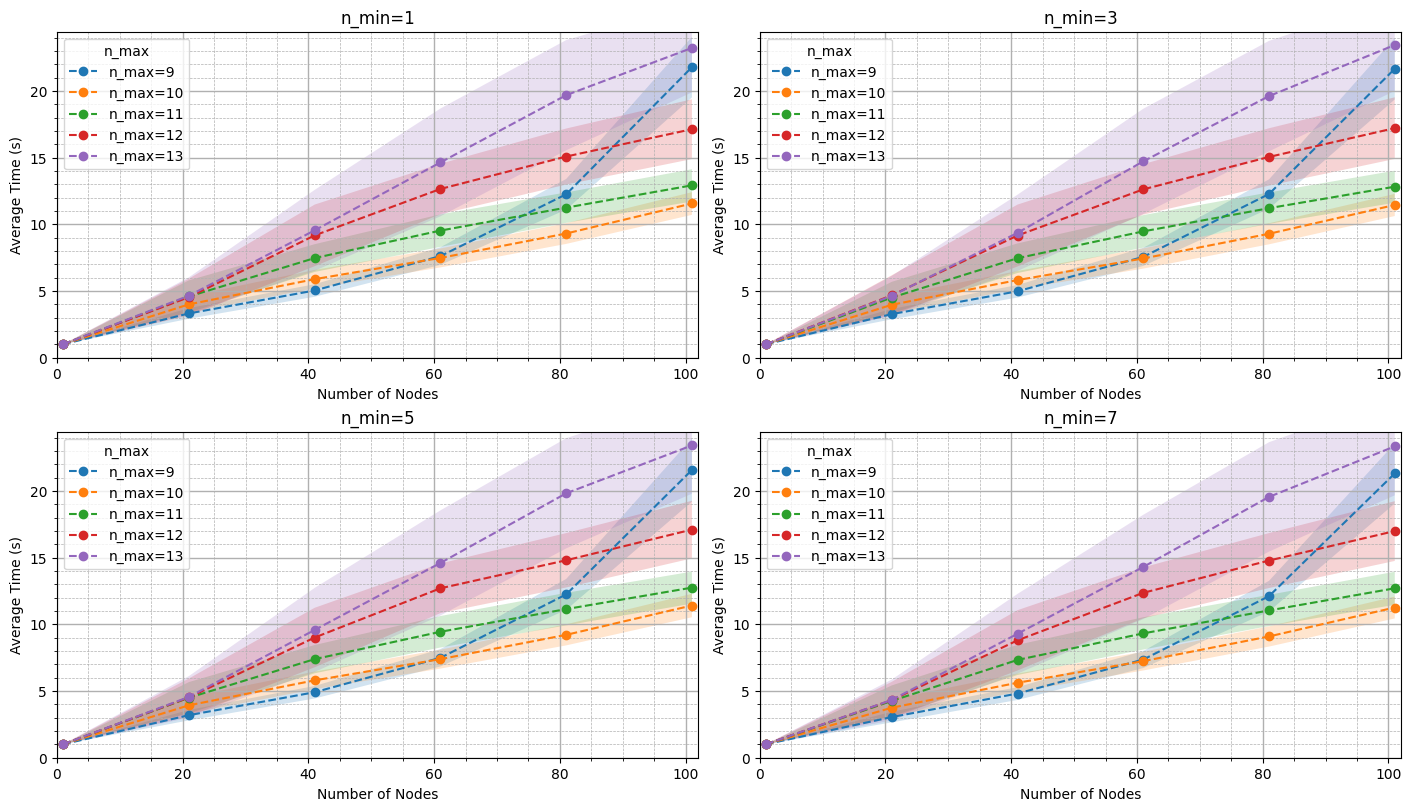

Slotframe with 113 slots of 2.02 ms each (total 228.71 ms):

↓↓↓S↓UUU↓UUUS↓UUU↓UUUS↓UUU↓UUUS↓UUU↓UUUS↓UUU↓UUUS↓UUU↓UUUS↓UUU↓UUUS↓UUU↓UUUS↓UUU↓UUUS↓UUU↓UUUS↓UUU↓UUUS↓UUU↓UUUUU

- Max nodes: 74 (number of data-up slots)

- MTU per slot: 256 B
- Slot duration: 2.02 ms (TOA: 1.02 ms, PAD: 1 ms)
- Number of slots per type: {'beacon': 3, 'data-shared-up': 12, 'data-down': 24, 'data-up': 74}
- Ratio of data-up to data-down slots: 3.08

Running:
  n_nodes = 1    n_min = 1 (n_max = 9 10 11 12 13 )  3 (n_max = 9 10 11 12 13 )  5 (n_max = 9 10 11 12 13 )  7 (n_max = 9 10 11 12 13 )  
  n_nodes = 15    n_min = 1 (n_max = 9 10 11 12 13 )  3 (n_max = 9 10 11 12 13 )  5 (n_max = 9 10 11 12 13 )  7 (n_max = 9 10 11 12 13 )  
  n_nodes = 29    n_min = 1 (n_max = 9 10 11 12 13 )  3 (n_max = 9 10 11 12 13 )  5 (n_max = 9 10 11 12 13 )  7 (n_max = 9 10 11 12 13 )  
  n_nodes = 43    n_min = 1 (n_max = 9 10 11 12 13 )  3 (n_max = 9 10 11 12 13 )  5 (n_max = 9 10 11 12 13 )  7 (n_max = 9 10 11 12 13 )  
  n_nodes = 57    n_min = 1 (n_max = 9 10 11 12 13 )  3 (n_max = 9 10 11 12 13 )  5 (n_max = 9 10 11 12 13 )  7 (n_max = 9 10 11 12 13 )  
  n_nodes = 74    n_min = 1 (n_max = 9 10 11 12 13 )  3 (n_max = 9 10 11 12 13 )  5 (n_max = 9 10 11 12 13 )  7 (n_max = 9 10 11 12 13 )  



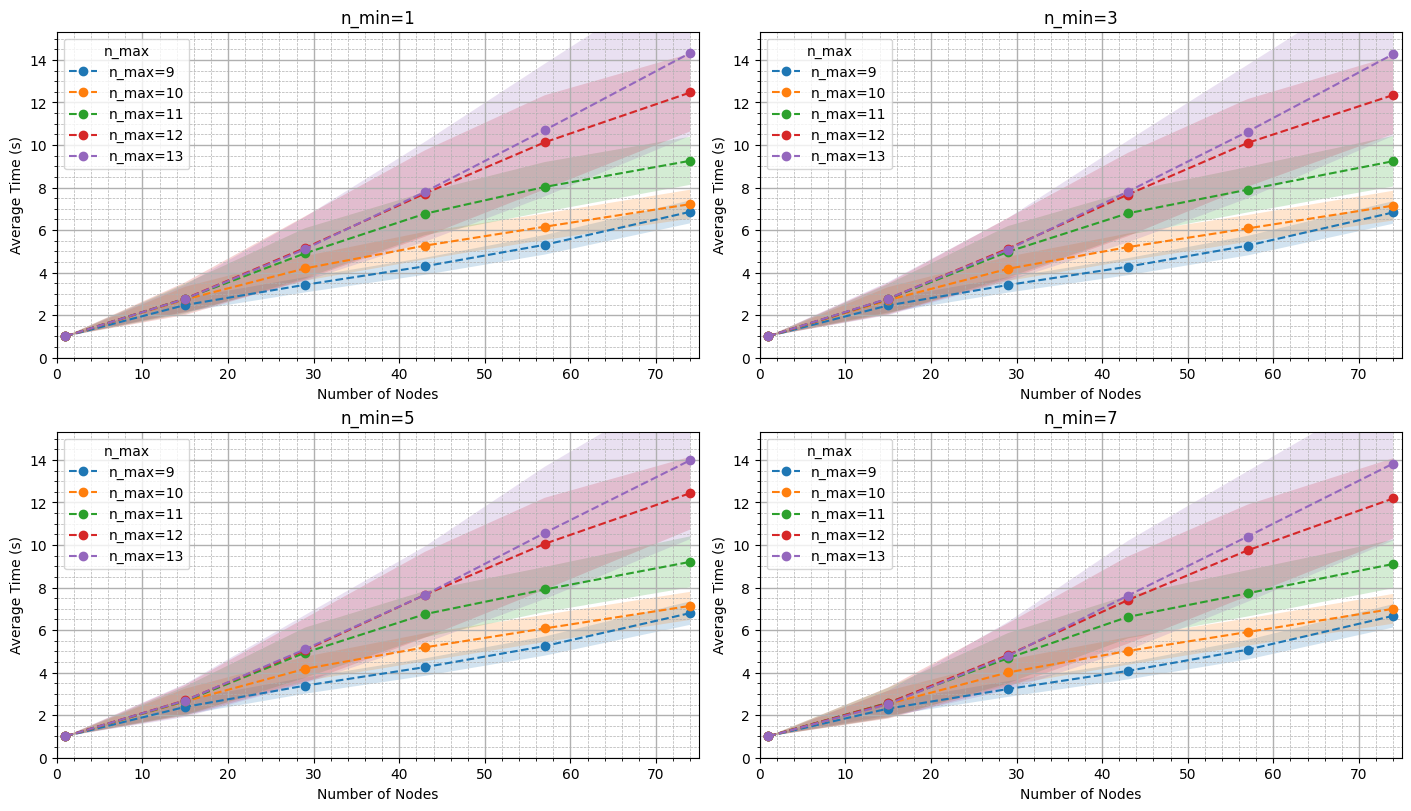

In [25]:

dfs_out = []
for key, value in selected_sfs.items(): # a good slotframe, with 101 nodes. n_max of 7 or 8 is unusable
    value["sf"].show_stats(compact=True)
    value["result_df"] = run_association_simulations(value["sf"], splits_nodes=5, range_n_min=[1, 3, 5, 7], range_n_max=range(9, 14), number_of_runs=1000, tag=key) # 1 run ~= 30s
    # value["result_df"] = run_association_simulations(value["sf"], splits_nodes=3, range_n_min=[3, 5, 7], range_n_max=range(9, 11), number_of_runs=20)
    plot_association_simulation_results_grid(value["result_df"], columns=2, tag=key)
    print("=====================================================================\n\n")

In [118]:
# sf = sf_configs.slotframes[0] # a good slotframe, with 101 nodes. n_max of 7 or 8 is unusable
# # sf = sf_configs.slotframes[-1] # a very simple slotframe

# sf.show_stats(compact=True)

# df = run_association_simulations(sf, splits_nodes=5, range_backoff=range(9, 15), number_of_runs=10)
# plot_association_simulation_results(df)

# Scratchpad

In [37]:
sf = sf_configs.slotframes[0].show_stats()

Latency(sf).show_stats()
OTAP(sf).show_stats(size=30_000)
Association(sf).show_stats()

Slotframe with 137 slots of 2.02 ms each (total 277.29 ms):

[B↓[B↓[B↓[S][D↓[U][U][U][U][D↓[U][U][U][U][U][S][D↓[U][U][U][U][D↓[U][U][U][U][U][S][D↓[U][U][U][U][D↓[U][U][U][U][
U][S][D↓[U][U][U][U][D↓[U][U][U][U][U][S][D↓[U][U][U][U][D↓[U][U][U][U][U][S][D↓[U][U][U][U][D↓[U][U][U][U][U][S][D
↓[U][U][U][U][D↓[U][U][U][U][U][S][D↓[U][U][U][U][D↓[U][U][U][U][U][S][D↓[U][U][U][U][D↓[U][U][U][U][U][S][D↓[U][U]
[U][U][D↓[U][U][U][U][U][S][D↓[U][U][U][U][D↓[U][U][U][U][U][U][U]

- Max nodes: 101 (number of data-up slots)

- MTU per slot: 256 B
- Slot duration: 2.02 ms (TOA: 1.02 ms, PAD: 1 ms)
- Number of slots per type: {'beacon': 3, 'data-shared-up': 11, 'data-down': 22, 'data-up': 101}
- Ratio of data-up to data-down slots: 4.59

Latency worst case:

- downlink/uplink reply:            269.19 ms
- uplink/downlink reply (estimate): 1386.45 ms

OTAP update:

- Image size: 30 kB
- Duration: 3.05 s

- Packets: 235
- swarmit_chunk_size: 128 B
- Needed slotframes: 11

Association time:

- Max time no collisions (estimate):            2772.9 ms

# Simulation

In [1054]:
sf_good = Slotframe.build_blocks2("SDUUUUDUUUUU", 11, "BBB")

sf_good.show_stats(compact=False)

Slotframe with 137 slots of 2.02 ms each (total 277.29 ms):

[B↓[B↓[B↓[S][D↓[U][U][U][U][D↓[U][U][U][U][U][S][D↓[U][U][U][U][D↓[U][U][U][U][U][S][D↓[U][U][U][U][D↓[U][U][U][U][
U][S][D↓[U][U][U][U][D↓[U][U][U][U][U][S][D↓[U][U][U][U][D↓[U][U][U][U][U][S][D↓[U][U][U][U][D↓[U][U][U][U][U][S][D
↓[U][U][U][U][D↓[U][U][U][U][U][S][D↓[U][U][U][U][D↓[U][U][U][U][U][S][D↓[U][U][U][U][D↓[U][U][U][U][U][S][D↓[U][U]
[U][U][D↓[U][U][U][U][U][S][D↓[U][U][U][U][D↓[U][U][U][U][U][U][U]

- Max nodes: 101 (number of data-up slots)

- MTU per slot: 256 B
- Slot duration: 2.02 ms (TOA: 1.02 ms, PAD: 1 ms)
- Number of slots per type: {'beacon': 3, 'data-shared-up': 11, 'data-down': 22, 'data-up': 101}
- Ratio of data-up to data-down slots: 4.59

Slotframe(slots=[Slot(B, 0, duration=2.02, asn=0, start=0.00), Slot(B, 1, duration=2.02, asn=1, start=2.02), Slot(B, 2, duration=2.02, asn=2, start=4.05), Slot(S, 3, duration=2.02, asn=3, start=6.07), Slot(D, 4, duration=2.02, asn=4, start=8.10), Slot(U, 5, duration=2.02, asn=5, start=10.12), Slot(U, 6, duration=2.02, asn=6, start=12.14), Slot(U, 7, duration=2.02, asn=7, start=14.17), Slot(U, 8, duration=2.02, asn=8, start=16.19), Slot(D, 9, duration=2.02, asn=9, start=18.22), Slot(U, 10, duration=2.02, asn=10, start=20.24), Slot(U, 11, duration=2.02, asn=11, start=22.26), Slot(U, 12, duration=2.02, asn=12, start=24.29), Slot(U, 13, duration=2.02, asn=13, start=26.31), Slot(U, 14, duration=2.02, asn=14, start=28.34), Slot(S, 15, duration=2.02, asn=15, start=30.36), Slot(D, 16, duration=2.02, asn=16, start=32.38), Slot(U, 17, duration=2.02, asn=17, start=34.41), Slot(U, 18, duration=2.02, asn=18, start=36.43), Slot(U, 19, duration=2.02, asn=19, start=38.46), Slot(U, 20, duration=2.02, a

In [855]:
# simple slotframe
sf_simple = Slotframe.build_blocks2("SDUUU", 3, "B", force_prime="U")

sf_simple.show()
sf_simple.slot_count, sf_simple.duration, sf_simple.max_nodes()

[B↓[S][D↓[U][U][U][S][D↓[U][U][U][S][D↓[U][U][U][U]

(17, 34.41, 10)

In [ ]:
# good slotframe
sf_good = Slotframe.build_blocks2("SDUUUUDUUUUU", 11, "BBB") # max 101 nodes
# sf_good = Slotframe.build_blocks2("SDUUUDUUU", 12, "BBB") # max 74 nodes

sf_good.show()
sf_good.slot_count, sf_good.duration, sf_good.max_nodes()

# sf_good

[B↓[B↓[B↓[S][D↓[U][U][U][U][D↓[U][U][U][U][U][S][D↓[U][U][U][U][D↓[U][U][U][U][U][S][D↓[U][U][U][U][D↓[U][U][U][U][
U][S][D↓[U][U][U][U][D↓[U][U][U][U][U][S][D↓[U][U][U][U][D↓[U][U][U][U][U][S][D↓[U][U][U][U][D↓[U][U][U][U][U][S][D
↓[U][U][U][U][D↓[U][U][U][U][U][S][D↓[U][U][U][U][D↓[U][U][U][U][U][S][D↓[U][U][U][U][D↓[U][U][U][U][U][S][D↓[U][U]
[U][U][D↓[U][U][U][U][U][S][D↓[U][U][U][U][D↓[U][U][U][U][U][U][U]

(137, 277.29, 101)

In [ ]:
@dataclass
class Packet:
    dst: int
    src: int = None
    id: int = None
    enqueued_at: float = None # timestamp when the packet was enqueued (to calculate latency)

    type_app: str = "status" # "status", "cmd", "ack"
    needs_ack: bool = False
    # ack_to: int = None # the packet id that this packet is an ack to

    original_enqueued_at: float = None # timestamp when the packet was first enqueued (to calculate latency of acks)

    def __post_init__(self):
        self.id = random.randint(0, 1_000_000)

    def __repr__(self):
        enqueued_at_rounded = round(self.enqueued_at, 2) if self.enqueued_at is not None else None
        return f"Packet(dst={self.dst}, src={self.src}, id={self.id}, type_app={self.type_app}, enqueued_at={enqueued_at_rounded})"

    def to_dict(self):
        return {k: v for k, v in asdict(self).items() if v is not None}

@dataclass
class Node:
    id: int
    sf: Slotframe = field(repr=False)
    status: str = "idle"  # idle, scanning, got_beacon, sent_join_request, joined

    n_min: int = 0 # minimum exponent for the backoff
    n_max: int = 7 # maximum exponent for the backoff

    tx_status_period: int = 1000 # ms, how often the node sends a status packet

    tx_needs_ack_period: int = None # ms, how often the node sends a packet that needs an ack
    last_tx_needs_ack_packet_ts: float = 0 # timestamp when the last packet that needs an ack was sent

    backoff_n: int = None # exponential backoff counter, increases after a collision until it reaches n_max
    backoff_random_time: int = 0 # random number of slots to wait before trying to join again, decremented each slot

    assigned_slot: int = None

    tx_queue: List[Packet] = field(default_factory=list)
    tx_queue_max_len: int = 5

    last_status_packet_ts: float = 0 # timestamp when the last status packet was sent

    # right now unused. remove?
    started_scanning_ts: float = None
    sent_join_request_ts: float = None
    joined_ts: float = None

    def __post_init__(self):
        self.downlink_stats = []

    def run_common_logic(self):
        self.verify_backoff_wait()

    def register_scanning(self, ts):
        self.status = "scanning"
        self.started_scanning_ts = ts

    def rx_beacon(self):
        self.status = "got_beacon"

    def tx_join_request(self, ts):
        self.status = "sent_join_request"
        self.sent_join_request_ts = ts

    def rx_join_response(self, ts):
        self.status = "joined"
        self.joined_ts = ts
        self.reset_backoff()  # Reset backoff after a successful join
        self.last_tx_needs_ack_packet_ts = ts # starts counting when node joins

    def rx_downlink(self, packet, slot):
        # print(f"~    Node {self.id} received downlink at {slot.id} = {round(slot.end, 2)} (latency was {round(slot.end - packet.enqueued_at, 2)} ms), {packet}")
        self.downlink_stats.append({
            "dst": packet.dst,
            "tx_ts": packet.enqueued_at,
            "rx_ts": slot.end,
            "needs_ack": packet.needs_ack,
            "is_ack": packet.type_app == "ack",
            "latency": round(slot.end - packet.enqueued_at, 2),
            # "packet": packet.to_dict(),
        })
        if packet.needs_ack:
            reply = Packet(dst=packet.src, src=self.id, enqueued_at=round(slot.end, 2), type_app="ack", original_enqueued_at=packet.enqueued_at)
            # queue may be full, so try to pop the oldest packet whose type is status
            if len(self.tx_queue) >= self.tx_queue_max_len:
                for i, p in enumerate(self.tx_queue):
                    if p.type_app == "status":
                        self.tx_queue.pop(i)
                        break
            # now, if there is space, append the ack to the end of the queue
            if len(self.tx_queue) < self.tx_queue_max_len:
                self.tx_queue.append(reply)

    def ready_to_tx(self):
        """Peek at the next packet to transmit."""
        if len(self.tx_queue) > 0:
            return self.tx_queue[0]

    def tx_uplink(self):
        """Transmit the next packet."""
        if len(self.tx_queue) > 0:
            return self.tx_queue.pop(0)

    def should_try_to_join(self):
        """Check if the node should try to join the network."""
        return self.status == "got_beacon" and self.backoff_random_time == 0

    def enqueue_override_old_status(self, packet):
        """Append a packet to the queue, overriding an old status packet if needed."""
        # queue may be full, so try to pop the oldest packet whose type is status
        if len(self.tx_queue) >= self.tx_queue_max_len:
            for i, p in enumerate(self.tx_queue):
                if p.type_app == "status":
                    self.tx_queue.pop(i)
                    break
        # now, if there is space, append the ack to the end of the queue
        if len(self.tx_queue) < self.tx_queue_max_len:
            self.tx_queue.append(packet)

    def maybe_enqueue_tx_packet(self, slot):
        """Enqueue a packet, but only every tx_status_period or tx_needs_ack_period ms."""
        if \
           self.tx_needs_ack_period\
           and self.status == "joined"\
           and slot.start - self.last_tx_needs_ack_packet_ts >= self.tx_needs_ack_period:
            packet = Packet(dst=GATEWAY_ID, src=self.id, enqueued_at=round(slot.start, 2), type_app="robot-request", needs_ack=True)

            self.enqueue_override_old_status(packet)

            self.last_tx_needs_ack_packet_ts = slot.start # reset the timer for next time a batch of needs-ack packets are sent
        elif\
          self.status == "joined" and\
          slot.start - self.last_status_packet_ts >= self.tx_status_period and\
          len(self.tx_queue) < self.tx_queue_max_len:
            packet = Packet(dst=GATEWAY_ID, src=self.id, enqueued_at=round(slot.start, 2), type_app="status")
            self.tx_queue.append(packet)
            # print(f"~  Node enqueued uplink at {slot.id} = {round(slot.start, 2)} -- {packet}")
            self.last_status_packet_ts = slot.start
            return packet

    # backoff functions
    def verify_backoff_wait(self):
        if self.backoff_random_time > 0:
            self.backoff_random_time -= 1

    def register_collision(self):
        if self.backoff_n is None:
            self.backoff_n = self.n_min
        else:
            # increment the n in [0, 2^n - 1], but only if n is less than the max
            self.backoff_n = min(self.backoff_n + 1, self.n_max)
         # choose a random number from [0, 2^n - 1]
        self.backoff_random_time = random.randint(0, 2 ** self.backoff_n - 1)

    def reset_backoff(self):
        self.backoff_n = None
        self.backoff_random_time = 0

    def __repr__(self):
        return f"Node(status={self.status}, backoff_n={self.backoff_n})"
    
    def repr_nice(self, compact=False):
        abbrev = {
            "idle": "I",
            "scanning": "S",
            "got_beacon": "B",
            "sent_join_request": "R",
            "joined": "J",
        }[self.status]
        color = "red"
        bg_color = "white"
        if self.status == "joined":
            color = "green"
            if self.assigned_slot is not None:
                bg_color = "yellow"
        return rich.text.Text(abbrev, style=f'bold {color} on {bg_color}')


GATEWAY_ID = 255
@dataclass
class Gateway:
    sf: Slotframe = field(repr=False)
    joined_nodes: List[Node] = field(default_factory=list)
    id: int = GATEWAY_ID
    tx_queue: List[Packet] = field(default_factory=list)
    tx_queue_max_len: int = 10
    tx_probability: float = 0.1

    tx_cmd_ack_period: int = None # ms, how often the gateway sends a command that needs an ack. None means never
    last_cmd_ack_packet_ts: int = 0

    uplink_stats = []
    # uplink_ack_stats = []

    def __post_init__(self):
        self.tx_queue_max_len = sf.max_nodes()

    def accept_join(self, node, slot):
        self.joined_nodes.append(node)
        if len(self.joined_nodes) == self.sf.max_nodes(): # last_cmd_ack_packet_ts starts counting when all nodes joined
            self.last_cmd_ack_packet_ts = slot.start
    
    def maybe_enqueue_tx(self, slot):
        """Enqueue one or more tx's for nodes.

        - if it is time to send a batch of packets that need ack
        - or if tx_probability allows sending a no-ack packet
        """
        if \
           self.tx_cmd_ack_period\
           and len(self.joined_nodes) == self.sf.max_nodes()\
           and slot.start - self.last_cmd_ack_packet_ts >= self.tx_cmd_ack_period:
            self.tx_queue = [] # clear the queue, ignoring the probabilistic packets scheduled previously
            [
                self.tx_queue.append(Packet(dst=node.id, enqueued_at=round(slot.start, 2), type_app="cmd", needs_ack=True))
                for node in self.joined_nodes
            ]
            self.last_cmd_ack_packet_ts = slot.start # reset the timer for next time a batch of needs-ack packets are sent
        elif \
           len(self.joined_nodes) > 0 and\
           len(self.tx_queue) < self.tx_queue_max_len and\
           random.random() < self.tx_probability:
            node = random.choice(self.joined_nodes)
            packet = Packet(dst=node.id, enqueued_at=round(slot.start, 2), type_app="cmd")
            self.tx_queue.append(packet)
            # print(f"~  Gateway enqueued downlink at {slot.id} = {round(slot.start, 2)} -- {packet}")
            return packet

    def rx_uplink(self, packet, slot):
        # print(f"~    Gateway received uplink at {slot.id} = {round(slot.end, 2)} (latency was {round(slot.end - packet.enqueued_at, 2)} ms), {packet}")
        self.uplink_stats.append({
            "src": packet.src,
            "tx_ts": packet.enqueued_at,
            "rx_ts": slot.end,
            "needs_ack": packet.needs_ack,
            "is_ack": packet.type_app == "ack",
            "latency": round(slot.end - packet.enqueued_at, 2),
            # "packet": packet.to_dict(),
        })
        if packet.needs_ack:
            reply = Packet(dst=packet.src, src=self.id, enqueued_at=round(slot.end, 2), type_app="ack", original_enqueued_at=packet.enqueued_at)
            # append if queue is not full (will be dropped if full)
            # should be fine for cases where the gateway is not too busy, i.e., tx_probability is low
            if len(self.tx_queue) < self.tx_queue_max_len:
                self.tx_queue.append(reply)
        # if packet.type_app == "ack":
        #     print(f"~    Gateway received ack at {slot.id} = {round(slot.end, 2)} (latency was {round(slot.end - packet.original_enqueued_at, 2)} ms), {packet}")

    def ready_to_tx(self):
        """Peek at the next packet to transmit."""
        if len(self.tx_queue) > 0:
            return self.tx_queue[0]

    def tx_downlink(self):
        """Transmit the next packet."""
        if len(self.tx_queue) > 0:
            return self.tx_queue.pop(0)


@dataclass
class SimConfig:
    sf: Slotframe
    nodes_setting: Union[int, str] = "min" # "min", "avg", "max", or number of nodes
    debug: bool = False
    n_min: int = 0
    n_max: int = 7

    operation_duration_ms: int = 1_000
    gateway_tx_probability: float = 0.1 # probability of the gateway transmitting a packet in a slot
    node_tx_status_period: int = 1000 # ms, how often the node sends a status packet

    # ms, how often the node sends a packet that needs an ack
    # for example, if a node needs to ask some data from the infrastructure
    node_tx_needs_ack_period: int = None

    # ms, how often the gateway sends a command that needs an ack
    # for example, when the gateway sends a "go to location x,y" to all nodes at once
    gateway_tx_cmd_ack_period: int = None

    node_can_tx_as_soon_as_joined: bool = False # whether the node should start transmitting as soon as it joined, or wait until all nodes joined

    def __post_init__(self):
        # make sure the sf is copied (not referenced)
        self.sf = Slotframe.build(self.sf.as_raw_abbreviations())
        self.node_tx_status_period = round(self.node_tx_status_period)
        if self.node_tx_needs_ack_period:
            self.node_tx_needs_ack_period = round(self.node_tx_needs_ack_period)
        if self.gateway_tx_cmd_ack_period:
            self.gateway_tx_cmd_ack_period = round(self.gateway_tx_cmd_ack_period)

    @property
    def n_nodes(self):
        if self.nodes_setting == "min":
            return 1
        elif self.nodes_setting == "max":
            return self.sf.max_nodes()
        elif self.nodes_setting == "avg":
            return math.ceil(self.sf.max_nodes() / 2)
        elif isinstance(self.nodes_setting, int):
            return self.nodes_setting
        else:
            raise ValueError(f"Unknown nodes setting: {self.nodes_setting}")

    def __repr__(self):
        return f"SimConfig(n_nodes={self.n_nodes})"

@dataclass
class OpenSwarmNetworkSimulation:
    """
    We want to simulate:
    - executing the slotframes in sequence, with e.g. 1 or MAX nodes
    - the association of nodes
    """
    config: SimConfig
    gw: Gateway = field(default=None, repr=False)
    nodes: List[Node] = field(default_factory=list, repr=False)
    executed_slots: any = field(default_factory=list, repr=False)

    complete_join_slot = None

    def __post_init__(self):
        self.gateway = Gateway(
            self.config.sf,
            tx_probability=self.config.gateway_tx_probability,
            tx_cmd_ack_period=self.config.gateway_tx_cmd_ack_period
        )
        self.nodes = [
            Node(
                i, self.config.sf,
                n_min=self.config.n_min, n_max=self.config.n_max,
                tx_status_period=self.config.node_tx_status_period,
                tx_needs_ack_period=self.config.node_tx_needs_ack_period
            )
            for i in range(self.config.n_nodes)
        ]
        self.sf_index = 0
        self.complete_join_slot = None

    def run(self):
        console = Console()
        [node.register_scanning(0) for node in self.nodes]
        while self.at_join_phase() or self.at_operational_phase():
            # print(f"asn {self.current_slot.asn}")
            had_new_join = False # for debugging

            [node.run_common_logic() for node in self.nodes]

            # ==== enqueue packets for transmission, for joined nodes, given configured conditions ====
            if self.nodes_can_already_send_data():
                self.gateway.maybe_enqueue_tx(slot=self.current_slot)

            # ==== enqueue status packets for transmission, if it is already time to do so (only if node is joined) ====
            if self.nodes_can_already_send_data():
                [
                    node.maybe_enqueue_tx_packet(slot=self.current_slot)
                    for node in self.nodes
                ]

            # execute based on the slot type
            if self.current_slot.abbrev == "B":
                [node.rx_beacon() for node in self.nodes if node.status == "scanning"]
            elif self.current_slot.abbrev == "S":
                # check for collisions (whether multiple nodes want to join at the same time)
                nodes_wanting_to_join = [node for node in self.nodes if node.should_try_to_join()]
                if len(nodes_wanting_to_join) == 1:
                    node = nodes_wanting_to_join[0]
                    node.tx_join_request(self.current_slot.start)
                    self.gateway.accept_join(node, self.current_slot)
                if len(nodes_wanting_to_join) > 0:
                    [node.register_collision() for node in nodes_wanting_to_join]
            elif self.current_slot.abbrev == "D":
                # get node that sent a join request, if any
                node = next((node for node in self.nodes if node.status == "sent_join_request"), None)
                if node:
                    node.rx_join_response(self.current_slot.start)
                    self.config.sf.assign_next_available_uplink_slot(node.id)
                    had_new_join = True
                else:
                    if self.nodes_can_already_send_data():
                        packet = self.gateway.ready_to_tx()
                        if packet:
                            node = next((node for node in self.nodes if node.id == packet.dst), None)
                            if not node:
                                raise ValueError(f"Node with address {packet.dst} not found")
                            self.gateway.tx_downlink()
                            node.rx_downlink(packet, self.current_slot)
            elif self.current_slot.abbrev == "U" and self.nodes_can_already_send_data():
                if self.has_scheduled_uptime():
                    # get assigned node
                    node = next((node for node in self.nodes if node.id == self.current_slot.assigned_node_id), None)
                    if node:
                        packet = node.ready_to_tx()
                        if packet:
                            node.tx_uplink()
                            self.gateway.rx_uplink(packet, self.current_slot)

            # ==== check if this slot marks the end of the join phase ====
            if had_new_join and self.complete_join_slot is None and self.all_nodes_joined():
                self.complete_join_slot = Slot(type=self.current_slot.type, start=self.current_slot.start, asn=self.current_slot.asn)
                # print(f"{self.complete_join_slot.repr_nice()}, all nodes joined")

            wrapped = self.advance_slot()

            # ==== for debugging =====
            if self.config.debug:
                if self.at_join_phase() and had_new_join:
                    clear_output(wait=True) # Clear previous output and reprint in the same cell
                    console.print(self.config.sf.repr_nice(True), soft_wrap=True)
                    time.sleep(0.005)
                elif self.at_operational_phase() and self.current_slot.asn % 1000 == 0:
                    clear_output(wait=True) # Clear previous output and reprint in the same cell
                    console.print(self.config.sf.repr_nice(True), soft_wrap=True)
                    console.print(f"Operation phase timestamp: {self.time_spent_at_operational_phase}")
                    time.sleep(0.005)

        return self

    def has_scheduled_uptime(self):
        return self.current_slot.assigned_node_id is not None

    def at_join_phase(self):
        return self.complete_join_slot is None

    @property
    def time_spent_at_operational_phase(self):
        n_executed_op_slots = self.current_slot.asn - self.complete_join_slot.asn
        return round(n_executed_op_slots * self.current_slot.duration, 2)

    def at_operational_phase(self):
        if self.at_join_phase():
            return False
        return self.time_spent_at_operational_phase <= self.config.operation_duration_ms

    def nodes_can_already_send_data(self):
        return self.at_operational_phase() or self.config.node_can_tx_as_soon_as_joined

    def all_nodes_joined(self):
        return all([node.status == "joined" for node in self.nodes])

    @property
    def current_slot(self):
        return self.config.sf.current

    @property
    def iterations(self):
        return len(self.executed_slots)

    @property
    def duration_complete_join(self):
        return self.complete_join_slot.start

    def advance_slot(self):
        self.executed_slots.append(self.current_slot)
        return self.config.sf.advance_slot()

    # statistics
    def get_gateway_uplink_stats_df(self):
        return pd.DataFrame(self.gateway.uplink_stats)
    
    def get_nodes_downlink_stats_df(self):
        nested_stats = [n.downlink_stats for n in self.nodes]
        flat_stats = [stat for stats in nested_stats for stat in stats]
        return pd.DataFrame(flat_stats)
    
    def save_stats(self, tag="example"):
        self.get_gateway_uplink_stats_df().to_csv(f"csv/gateway_uplink_stats_{tag}.csv")
        self.get_nodes_downlink_stats_df().to_csv(f"csv/nodes_downlink_stats_{tag}.csv")
        return

    # show it
    def show(self):
        console = Console()
        # console.print("gateway", self.gateway.uplink_stats[:10])
        # console.print("gateway ack", [stat for stat in self.gateway.uplink_stats if stat["is_ack"]][:10])
        # console.print("nodes", [n.downlink_stats for n in self.nodes[:2]])
        # console.print("nodes ack", [[stat for stat in n.downlink_stats if stat["is_ack"]] for n in self.nodes[:2]])
        console.print(f"""\
Finished simulation with {len(self.nodes)} nodes:

==== Association phase ====
- Done after {self.duration_complete_join/1000:.2f} s (asn {self.complete_join_slot.asn})
- Slots in frame: {self.config.sf.slot_count}    {self.config.sf.count_slots_per_type()}
- Association slot: {self.current_slot}
- Association ASN: {self.current_slot.asn}

==== Operational phase ====
- Ran from {self.complete_join_slot.start/1000:.2f} s to {self.current_slot.start/1000:.2f} s

Gateway:
- Received uplink count: {len(self.gateway.uplink_stats)}
- Average latency: {np.mean([stat["latency"] for stat in self.gateway.uplink_stats]):.2f} ms (±{np.std([stat["latency"] for stat in self.gateway.uplink_stats]):.2f})

Nodes:
- Received downlink count: {sum([len(node.downlink_stats) for node in self.nodes])}
- Per-node downlink count: {[len(node.downlink_stats) for node in self.nodes]}
- Average latency: {np.mean([stat["latency"] for node in self.nodes for stat in node.downlink_stats]):.2f} ms (±{np.std([stat["latency"] for node in self.nodes for stat in node.downlink_stats]):.2f})


The used TSCH schedule is:\
""")
        # console.print(self.config.sf.repr_nice(compact=False))
        self.config.sf.show_stats(compact=False)
        return self

    def __repr__(self):
        return f"OpenSwarmNetworkSimulation(config={self.config}, stopped_at={self.executed_slots[-1]})"

sim_config = SimConfig(
    nodes_setting="max",

    # sf=sf_simple, operation_duration_ms=sf_simple.duration * 30,
    # node_tx_status_period=sf_simple.duration * 1.1, node_tx_needs_ack_period=sf_simple.duration * 6,
    # gateway_tx_probability=0.1, gateway_tx_cmd_ack_period=sf_simple.duration * 7,

    sf=sf_good, operation_duration_ms=60_000 * 1,
    node_tx_status_period=sf_good.duration * 1.1, node_tx_needs_ack_period=5000,
    gateway_tx_probability=0.1, gateway_tx_cmd_ack_period=15_000,

    node_can_tx_as_soon_as_joined=True,
    n_min=3, n_max=9, # association backoff parameters
    debug=True,
)
sim = OpenSwarmNetworkSimulation(sim_config).run().show()
sim.save_stats(tag="example")

↓↓↓S↓UUUU↓UUUUUS↓UUUU↓UUUUUS↓UUUU↓UUUUUS↓UUUU↓UUUUUS↓UUUU↓UUUUUS↓UUUU↓UUUUUS↓UUUU↓UUUUUS↓UUUU↓UUUUUS↓UUUU↓UUUUUS↓UUUU↓UUUUUS↓UUUU↓UUUUUUU

Operation phase timestamp: 599571.54

Finished simulation with 101 nodes:

==== Association phase ====
- Done after 23.82 s (asn 11769)
- Slots in frame: 137    {'beacon': 3, 'data-shared-up': 11, 'data-down': 22, 'data-up': 101}
- Association slot: Slot(S, 99, duration=2.02, asn=308212, start=623825.59)
- Association ASN: 308212

==== Operational phase ====
- Ran from 23.82 s to 623.83 s

Gateway:
- Received uplink count: 216527
- Average latency: 281.07 ms (±142.13)

Nodes:
- Received downlink count: 42053
- Per-node downlink count: [482, 393, 379, 436, 375, 405, 449, 395, 363, 412, 446, 419, 440, 415, 502, 375, 397, 
354, 397, 394, 406, 457, 403, 384, 468, 443, 396, 419, 427, 397, 435, 434, 387, 376, 360, 411, 485, 541, 428, 399, 
408, 365, 432, 415, 430, 439, 376, 419, 412, 416, 419, 461, 429, 432, 414, 442, 448, 414, 417, 421, 387, 441, 401, 
437, 413, 413, 437, 387, 408, 380, 417, 421, 464, 428, 405, 369, 438, 370, 426, 421, 415, 407, 408, 417, 391, 393, 
381, 358, 435, 436, 435, 443, 396, 423, 406, 460, 443, 370, 396, 361, 523]
- Average latency: 89.29 ms (±209.98)


The used TSCH schedule is:

Slotframe with 137 slots of 2.02 ms each (total 277.29 ms):

[B↓[B↓[B↓[S][D↓[100][14][36][24][D↓[37][52][76][63][0][S][D↓[21][51][12][90][D↓[25][56][61][96][73][S][D↓[78][55][6
2][2][D↓[32][35][87][66][58][S][D↓[39][53][1][16][D↓[38][40][71][9][49][S][D↓[3][13][98][46][D↓[45][42][67][41][69]
[S][D↓[8][75][33][97][D↓[34][17][77][23][95][S][D↓[19][48][88][80][D↓[70][83][82][43][27][S][D↓[47][26][50][29][D↓[
59][74][57][94][60][S][D↓[91][64][54][68][D↓[22][84][81][20][4][S][D↓[5][15][11][28][D↓[6][93][44][18][30][S][D↓[72
][85][79][10][D↓[65][89][31][7][86][92][99]

- Max nodes: 101 (number of data-up slots)

- MTU per slot: 256 B
- Slot duration: 2.02 ms (TOA: 1.02 ms, PAD: 1 ms)
- Number of slots per type: {'beacon': 3, 'data-shared-up': 11, 'data-down': 22, 'data-up': 101}
- Ratio of data-up to data-down slots: 4.59

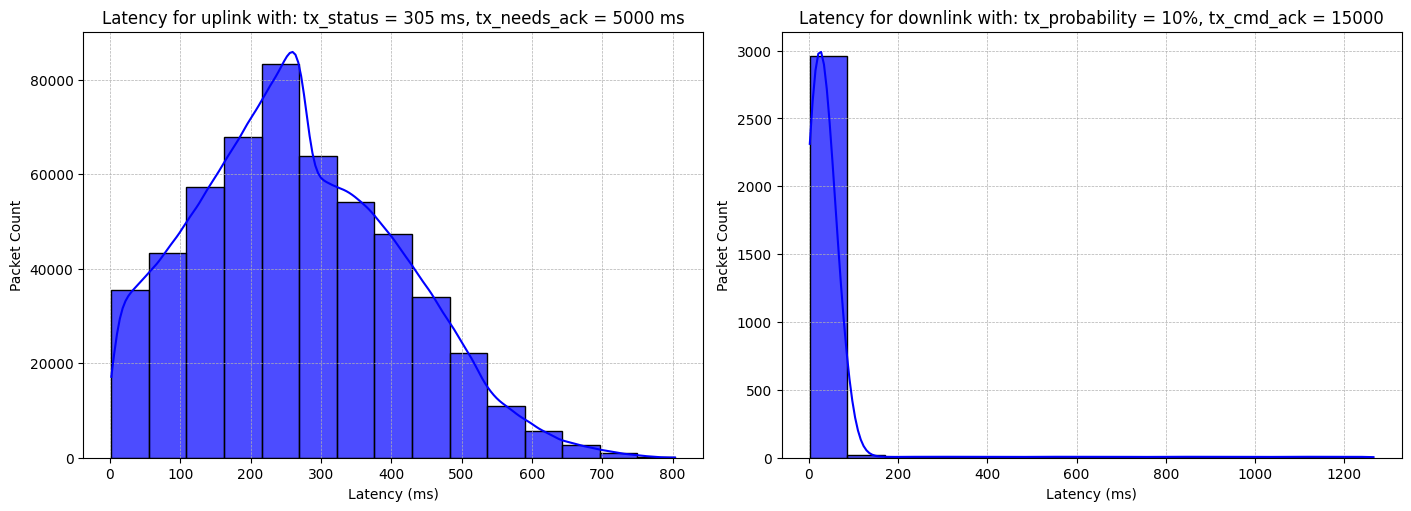

In [1274]:
def plot_latency_distribution_side_by_side(uplink_df, downlink_df, uplink_name, downlink_name, tag=""):
    """
    Plot the latency distribution of uplink and downlink DataFrames side by side.

    Args:
    - uplink_df: DataFrame containing the uplink latency data.
    - downlink_df: DataFrame containing the downlink latency data.
    - uplink_name: Title for the uplink plot.
    - downlink_name: Title for the downlink plot.
    - tag: Optional tag for saving the figure.
    """
    fig, axes = plt.subplots(1, 2, figsize=(14, 5), constrained_layout=True)

    # Uplink plot
    sns.histplot(uplink_df['latency'], bins=15, kde=True, ax=axes[0], color='blue', edgecolor='black', alpha=0.7)
    axes[0].set_xlabel('Latency (ms)')
    axes[0].set_ylabel('Packet Count')
    axes[0].set_title(f'Latency for {uplink_name}')
    axes[0].grid(True, which='major', linestyle='--', linewidth=0.5)

    # Downlink plot
    sns.histplot(downlink_df['latency'], bins=15, kde=True, ax=axes[1], color='blue', edgecolor='black', alpha=0.7)
    axes[1].set_xlabel('Latency (ms)')
    axes[1].set_ylabel('Packet Count')
    axes[1].set_title(f'Latency for {downlink_name}')
    axes[1].grid(True, which='major', linestyle='--', linewidth=0.5)

    # Save the figure if a tag is provided
    if tag:
        plt.savefig(f"fig/latency_distribution-{tag}.pdf")
    plt.show()

plot_latency_distribution_side_by_side(
    uplink_df=sim.get_gateway_uplink_stats_df(),
    downlink_df=sim.get_nodes_downlink_stats_df(),
    uplink_name=f"uplink with: tx_status = {sim.config.node_tx_status_period} ms, tx_needs_ack = {sim.config.node_tx_needs_ack_period} ms",
    downlink_name=f"downlink with: tx_probability = {round(sim.config.gateway_tx_probability * 100)}%, tx_cmd_ack = {sim.config.gateway_tx_cmd_ack_period}",
    tag="example_uplink_downlink"
)


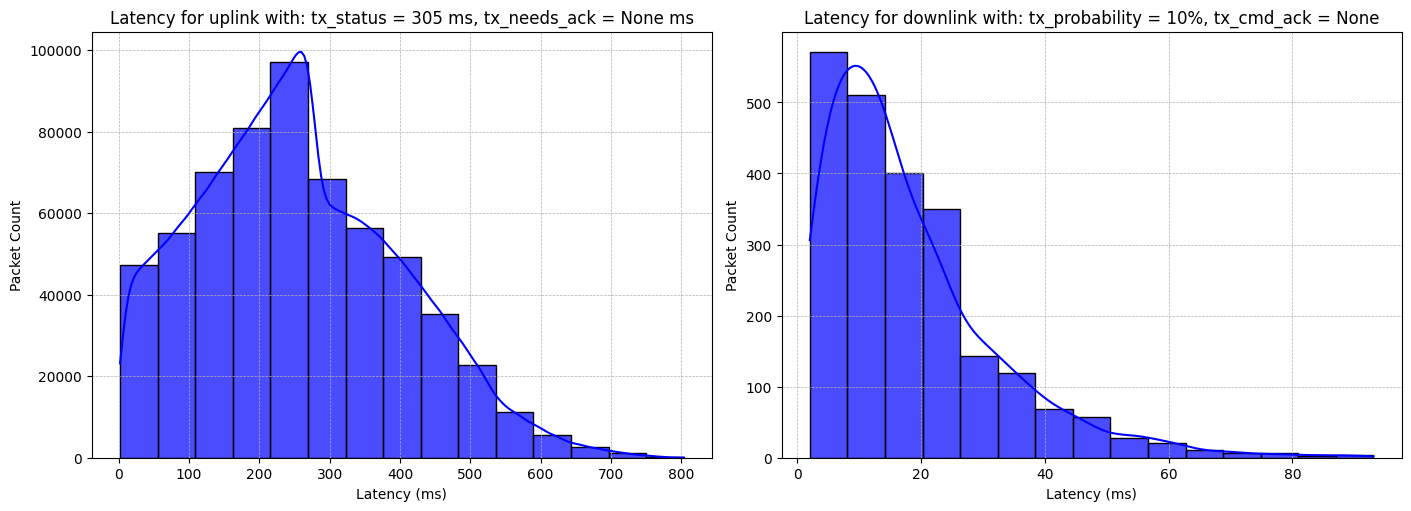

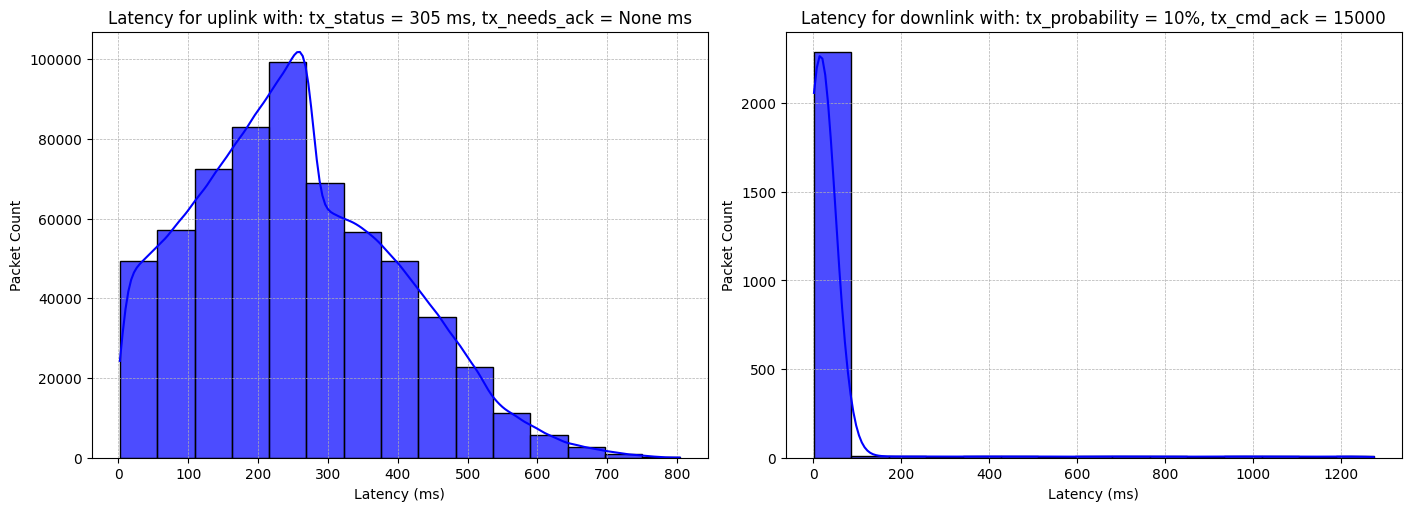

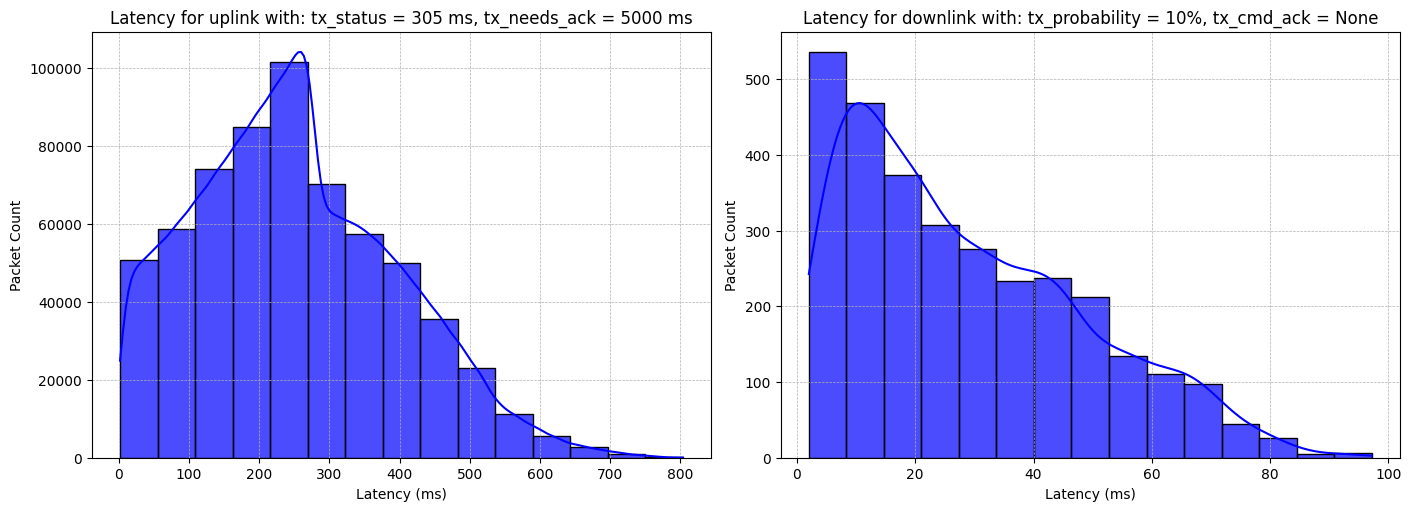

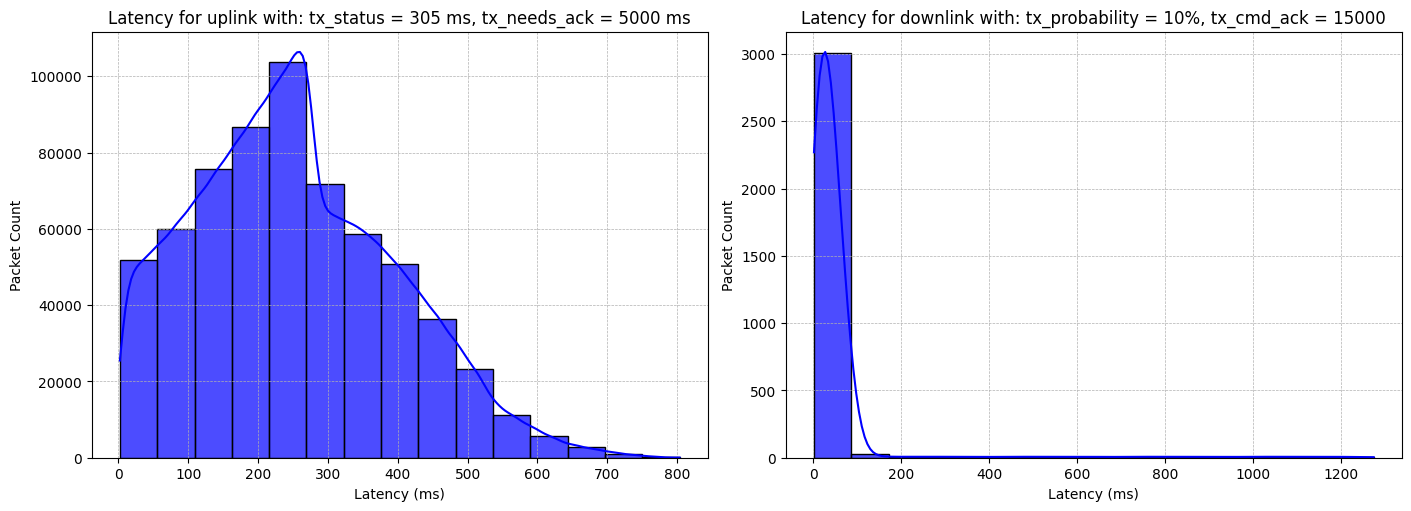

In [ ]:
node_tx_periods = [None, 5000]
gateway_tx_periods = [None, 15000]

tx_status_period = round(sf_good.duration * 1.1)
tx_probability = 0.1

results_latency = []

for node_tx_period in node_tx_periods:
    for gateway_tx_period in gateway_tx_periods:
        sim_config = SimConfig(
            nodes_setting="max",

            sf=sf_good, operation_duration_ms=30_000 * 1,
            node_tx_status_period=tx_status_period, node_tx_needs_ack_period=node_tx_period,
            gateway_tx_probability=tx_probability, gateway_tx_cmd_ack_period=gateway_tx_period,

            node_can_tx_as_soon_as_joined=True,
            n_min=3, n_max=9, # association backoff parameters
            debug=False,
        )

        sim = OpenSwarmNetworkSimulation(sim_config).run()
        sim.save_stats(tag=f"sf_101_n-{node_tx_period}_g-{gateway_tx_period}")

        results_latency.append({
            "node_tx_period": node_tx_period,
            "gateway_tx_period": gateway_tx_period,
            "gateway_uplink": sim.get_gateway_uplink_stats_df(),
            "nodes_downlink": sim.get_nodes_downlink_stats_df(),
        })

for res in results_latency:
    plot_latency_distribution_side_by_side(
        uplink_df=res["gateway_uplink"],
        downlink_df=res["nodes_downlink"],
        uplink_name=f"uplink with: tx_status = {tx_status_period} ms, tx_needs_ack = {res['node_tx_period']} ms",
        downlink_name=f"downlink with: tx_probability = {round(tx_probability * 100)}%, tx_cmd_ack = {res['gateway_tx_period']} ms",
        tag=f"sf_101-n-{res['node_tx_period']}-g-{res['gateway_tx_period']}"
    )


For this slotframe configuration:


↓↓↓S↓UUUU↓UUUUUS↓UUUU↓UUUUUS↓UUUU↓UUUUUS↓UUUU↓UUUUUS↓UUUU↓UUUUUS↓UUUU↓UUUUUS↓UUUU↓UUUUUS↓UUUU↓UUUUUS↓UUUU↓UUUUUS↓UUUU↓UUUUUS↓UUUU↓UUUUUUU

Running:
  n_nodes = 1    n_min = 3 (n_max = 9 10 11 )  4 (n_max = 9 10 11 )  
  n_nodes = 34    n_min = 3 (n_max = 9 10 11 )  4 (n_max = 9 10 11 )  
  n_nodes = 67    n_min = 3 (n_max = 9 10 11 )  4 (n_max = 9 10 11 )  
  n_nodes = 101    n_min = 3 (n_max = 9 10 11 )  4 (n_max = 9 10 11 )  



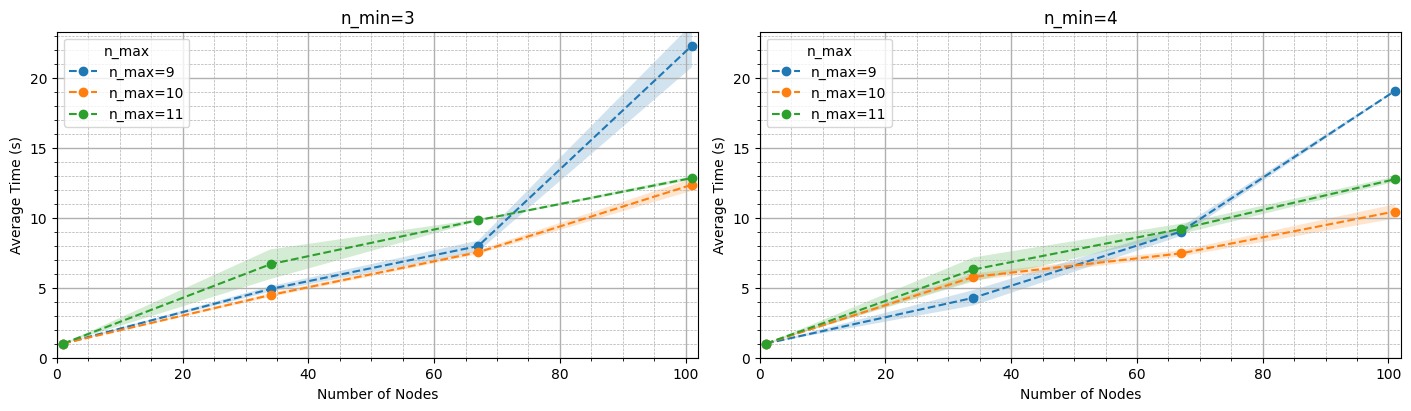

In [ ]:
def run_association_simulations(sf, splits_nodes=4, range_n_min=range(0, 5), range_n_max=range(8, 14), number_of_runs=20, tag=None):
        
    records = []

    print(f"Running:")
    n_nodes_range = list(range(1, sf.max_nodes() + 1, int(sf.max_nodes() / splits_nodes)))
    if n_nodes_range[-1] != sf.max_nodes():
        n_nodes_range[-1] = sf.max_nodes()

    for n_nodes in n_nodes_range:
        print(f"  n_nodes = {n_nodes}    n_min = ", end="")
        for n_min in range_n_min:
            print(f"{n_min} (n_max = ", end="")
            for n_max in range_n_max:
                print(n_max, end=" ")
                times = [
                    OpenSwarmNetworkSimulation(SimConfig(sf, n_nodes, debug=False, n_min=n_min, n_max=n_max)).run().duration
                    for _ in range(number_of_runs)
                ]
                # get avg and std
                records.append({
                    "n_nodes": n_nodes,
                    "n_min": n_min,
                    "n_max": n_max,
                    "avg": round(np.mean(times) / 1000, 2),
                    "std": round(np.std(times) / 1000, 2),
                })
            print(")  ", end="")
        print("")
    print("")

    df = pd.DataFrame(records)
    if tag:
        df.to_csv(f"csv/assoc-time-{tag}.csv")
    return df

# sf = sf_simple
sf = sf_configs.slotframes[0]

print("For this slotframe configuration:")
sf.show(compact=True)

# df = run_association_simulations(sf, splits_nodes=3, range_n_min=range(3, 4), range_n_max=range(9, 11), number_of_runs=2) # -> fixed n_min = 3
df = run_association_simulations(sf, splits_nodes=3, range_n_min=range(3, 5), range_n_max=range(9, 12), number_of_runs=2, tag="example") # variable n_min
# display(df)
plot_association_simulation_results_grid(df)

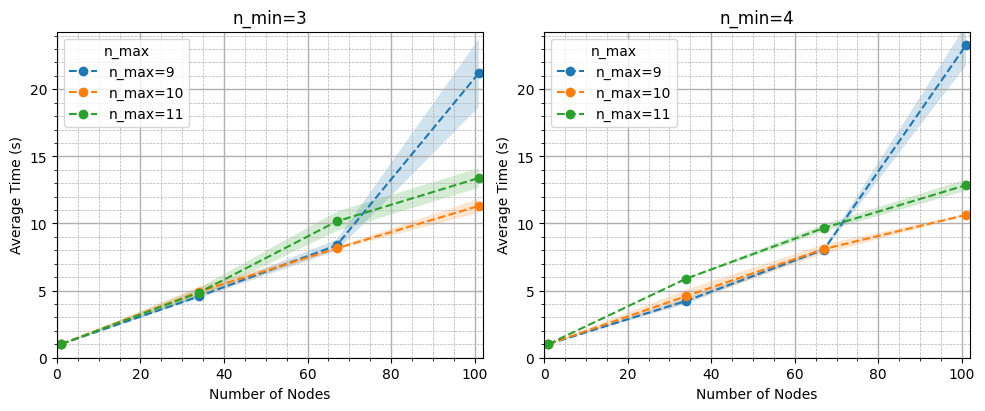

In [20]:
def plot_association_simulation_results_grid(df, tag=None, columns=2):
    # Precompute consistent axis limits
    x_min, x_max = df['n_nodes'].min(), df['n_nodes'].max()
    y_min, y_max = df['avg'].min(), df['avg'].max()

    # Get unique n_min values and set up grid layout
    n_min_values = sorted(df['n_min'].unique())
    rows = math.ceil(len(n_min_values) / columns)

    fig, axes = plt.subplots(rows, columns, figsize=(14, rows * 4), constrained_layout=True)

    # Flatten axes array for easier indexing
    axes = axes.flatten()

    # Loop through each n_min and its corresponding subplot
    for idx, n_min in enumerate(n_min_values):
        ax = axes[idx]
        group_min = df[df['n_min'] == n_min]

        # Group by n_max for each n_min
        for n_max, group in group_min.groupby('n_max'):
            ax.plot(
                group['n_nodes'],
                group['avg'],
                '--o',
                label=f'n_max={n_max}'
            )
            ax.fill_between(
                group['n_nodes'],
                group['avg'] - group['std'],
                group['avg'] + group['std'],
                alpha=0.2
            )

        # Set axis limits for consistency
        ax.set_xlim(0, x_max + 1)
        ax.set_ylim(0, y_max + 1)

        # Add labels, title, and grid
        ax.set_xlabel('Number of Nodes')
        ax.set_ylabel('Average Time (s)')
        ax.set_title(f'n_min={n_min}')
        ax.grid(True, which='major', linestyle='-', linewidth=1.0)
        ax.grid(True, which='minor', linestyle='--', linewidth=0.5)
        ax.minorticks_on()
        ax.legend(title='n_max', loc='upper left')

    # Hide unused subplots if any
    for i in range(len(n_min_values), len(axes)):
        fig.delaxes(axes[i])

    # Save the grid figure if a tag is provided
    if tag:
        plt.savefig(f"fig/assoc-time-grid-{tag}.pdf")
    plt.show()

# Example usage
plot_association_simulation_results_grid(df, tag="grid_example", columns=3)